# Visualisieren von Temperaturdaten

In [2]:
import sqlite3 as db
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # Mehrere Temperatursensoren in einem Boxplot als categorial-Plot

#connect to database or create if doesn't exist
conn = db.connect('../data/230130_home-assistant_v2.db')

In [3]:
%matplotlib widget

## Hilfsfunktionen

In [6]:
# Temperaturdaten einlesen
def read_temp(conn, name):

    data = pd.read_sql_query(f"""
    SELECT start AS Time, mean AS Temperature
    FROM statistics 
    WHERE metadata_id IN (SELECT id FROM statistics_meta WHERE statistic_id = "{name}") 
    AND min > -20 
    AND max < 40;
    """, conn, parse_dates=["Time"])

    # Zeiten selektieren
    #data[data["Time"] > "2022-01-18"]

    # Index nicht mehr numerisch, sondern das Datetime-Feld nutzen
    data = data.set_index('Time')
    return data

def search_entity(conn, search_string):

    data = pd.read_sql_query(f"""
    SELECT A.entity_id, attributes
    FROM (SELECT DISTINCT entity_id, (SELECT shared_attrs FROM state_attributes WHERE states.attributes_id = state_attributes.attributes_id) as attributes
    FROM states
    GROUP BY entity_id) AS A
    WHERE A.attributes LIKE "%{search_string}%";
    """, conn, parse_dates=["Time"])

    return data

In [88]:
pd.options.display.max_colwidth = 200
search_entity(conn,"garage")

,entity_id,attributes
0,sensor.garage_1_1_1d,"{""state_class"":""total"",""last_reset"":""2023-01-28T00:00:00+01:00"",""unit_of_measurement"":""kWh"",""device_class"":""energy"",""friendly_name"":""Garage 1 1 1D""}"
1,sensor.garage_1_1_1min,"{""state_class"":""measurement"",""device_class"":""power"",""friendly_name"":""Garage 1 1 1MIN"",""unit_of_measurement"":""W""}"
2,sensor.garage_1_1_1mon,"{""state_class"":""total"",""last_reset"":""2023-01-01T00:00:00+01:00"",""unit_of_measurement"":""kWh"",""device_class"":""energy"",""friendly_name"":""Garage 1 1 1MON""}"
3,sensor.garage_2_2_1d,"{""state_class"":""total"",""last_reset"":""2023-01-28T00:00:00+01:00"",""unit_of_measurement"":""kWh"",""device_class"":""energy"",""friendly_name"":""Garage 2 2 1D""}"
4,sensor.garage_2_2_1min,"{""state_class"":""measurement"",""device_class"":""power"",""friendly_name"":""Garage 2 2 1MIN"",""unit_of_measurement"":""W""}"
5,sensor.garage_2_2_1mon,"{""state_class"":""total"",""last_reset"":""2023-01-01T00:00:00+01:00"",""unit_of_measurement"":""kWh"",""device_class"":""energy"",""friendly_name"":""Garage 2 2 1MON""}"
6,sensor.garage_3_3_1d,"{""state_class"":""total"",""last_reset"":""2023-01-28T00:00:00+01:00"",""unit_of_measurement"":""kWh"",""device_class"":""energy"",""friendly_name"":""Garage 3 3 1D""}"
7,sensor.garage_3_3_1min,"{""state_class"":""measurement"",""device_class"":""power"",""friendly_name"":""Garage 3 3 1MIN"",""unit_of_measurement"":""W""}"
8,sensor.garage_3_3_1mon,"{""state_class"":""total"",""last_reset"":""2023-01-01T00:00:00+01:00"",""unit_of_measurement"":""kWh"",""device_class"":""energy"",""friendly_name"":""Garage 3 3 1MON""}"
9,sensor.garage_gefilterte_luftfeuchtigkeit,"{""state_class"":""measurement"",""entity_id"":""sensor.26_00003824da00_humidity_htm1735"",""unit_of_measurement"":""%"",""device_class"":""humidity"",""icon"":""mdi:chart-line-variant"",""friendly_name"":""Garage Gefil..."


## Temperaturdaten
Wir wollen den Daten die **offiziellen Temperaturdaten als Referenz** gegenüberstellen.

Daten vom DWD herunterladen, für [Chemnitz historisch](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/) 

Daten vom DWD herunterladen, für [Chemnitz aktuell](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/stundenwerte_TU_00853_akt.zip) 

(Station: 00853)


In [57]:
import requests       # Für Web-Download
import zipfile        # Für Zip entpacken
import glob           # Für Dateinamen finden

# Daten herunterladen

#url = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/stundenwerte_TU_00853_19510101_20211231_hist.zip'
#r = requests.get(url, allow_redirects=True)
#open('temp_date_hist.zip', 'wb').write(r.content)

url = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/stundenwerte_TU_00853_akt.zip'
r = requests.get(url, allow_redirects=True)
open('../data/chemnitz_temp_stundenwerte.zip', 'wb').write(r.content)

# Zip-Archiv entpacken

with zipfile.ZipFile('../data/chemnitz_temp_stundenwerte.zip', 'r') as zip_ref:
    zip_ref.extractall('../data/chemnitz_temp_stundenwerte')

# Dateinamen finden (Der Dateiname im Zip-File ist dynamisch)
fname = glob.glob('../data/chemnitz_temp_stundenwerte/produkt_tu_stunde_*.txt')[0]
print(f"Folgende Datei wird geöffnet:\n {fname}")


Folgende Datei wird geöffnet:
 ../data/chemnitz_temp_stundenwerte/produkt_tu_stunde_20210729_20230129_00853.txt


In [61]:
data = pd.read_csv(fname, delimiter=";", dtype={'MESS_DATUM':pd.StringDtype()})

# Datumsspalte in Datetime-Typ umwandeln und als Index verwenden
data['Time'] = pd.to_datetime(data['MESS_DATUM'], format='%Y%m%d%H')
data = data.set_index('Time')

# ggf. Daten einschränken (Debugging)
#data = data["2022-07-20":"2022-08-20"]

# Wir benötigen nur die Temperaturdaten
t_dwd = data['TT_TU']

## Visualisierungen, Boxplot

In [91]:
# Temperaturdaten aus Home Assistant laden und in Tabelle mit Wetterdaten des DWD gegenüberstellen

#t_studio = (read_temp(conn, "sensor.28_ff5ad9501603_temperature"))["2022-07-21":"2022-08-20"]['Temperature']
t_studio = (read_temp(conn, "sensor.28_ff5ad9501603_temperature"))['Temperature']
plotdata = pd.concat([t_dwd[t_studio.index.min():t_studio.index.max()], t_studio], axis=1)
plotdata = plotdata.rename(columns={"TT_TU": "T_Außen", "Temperature": "T_Studio"})

# Weiteren Sensor hinzufügen
t_garage = (read_temp(conn, "sensor.garage_temperatur"))['Temperature']
plotdata = pd.concat([plotdata, t_garage], axis=1)
plotdata = plotdata.rename(columns={"Temperature": "T_Garage"})

# Plot vorbereiten (Gruppierung für x-Achse)
plotdata['TimeGroup'] = plotdata.index.to_period('M')

# Daten vertikal anordnen -> Klassen (Tempsensor1 und Tempsensor2) nicht mehr nebeneinander, sondern als Spalte mit Klassenbezeichnung 
catplotdata = plotdata.melt(id_vars=['TimeGroup'], var_name='Sensor', value_name='Temperatur')


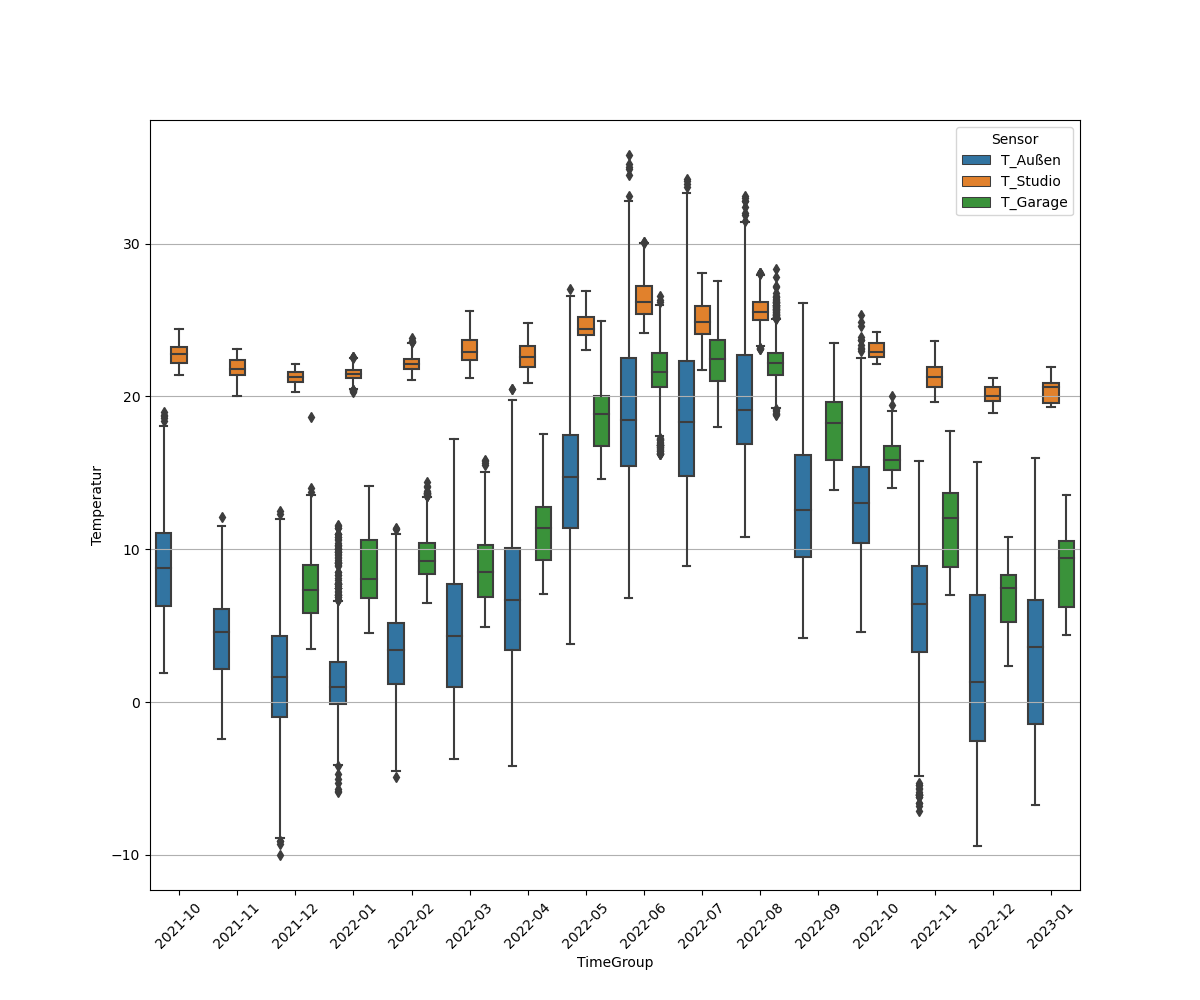

In [93]:
# Plotten mittels Seaborn
h = plt.figure(figsize=(12, 10))
ax = h.gca()
ax.yaxis.grid(True)
sns.boxplot(data=catplotdata, x='TimeGroup', y='Temperatur', hue='Sensor', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);


Text(0.5, 0.98, '')

findfont: Font family ['LiberationSans'] not found. Falling back to DejaVu Sans.


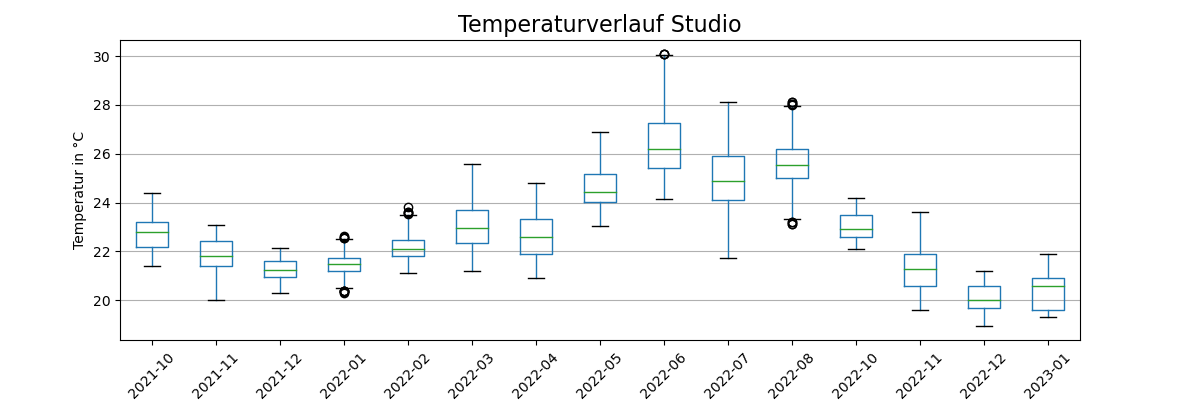

In [5]:
plotdata = read_temp(conn, "sensor.28_ff5ad9501603_temperature")
plotdata['TimeGroup'] = plotdata.index.to_period('M')
h = plt.figure(figsize=(12, 4))
ax = h.gca()
plotdata.boxplot(by='TimeGroup',column='Temperature',rot=45,ax=ax)
ax.grid(axis='x')
ax.set_title("Temperaturverlauf Studio",font='LiberationSans', size=16)
ax.set_ylabel("Temperatur in °C")
h.suptitle('')

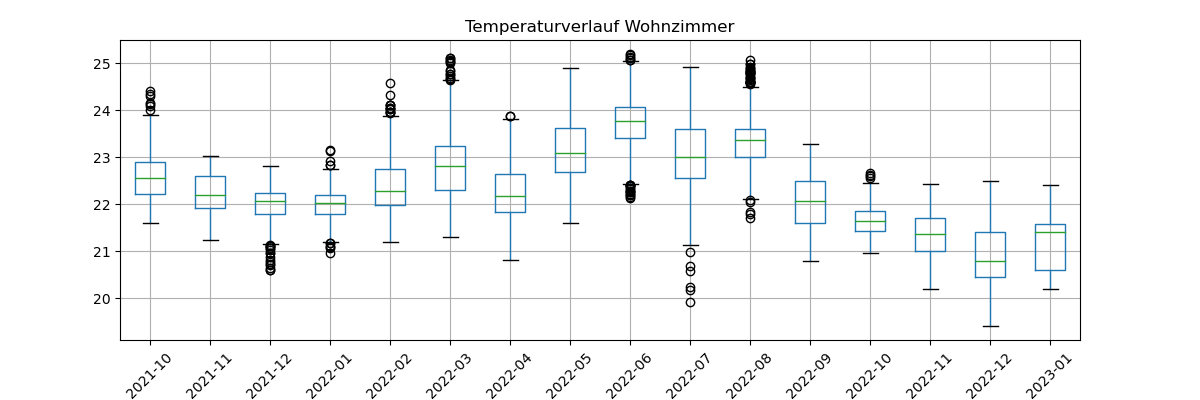

In [94]:
data = pd.read_sql_query("""
SELECT start AS Time, mean AS Temperature
FROM statistics 
WHERE metadata_id IN (SELECT id FROM statistics_meta WHERE statistic_id = "sensor.28_ff380fb41603_temperature") 
AND min > -20 
AND max < 40;
""", conn, parse_dates=["Time"]).set_index('Time')
data['TimeGroup'] = data.index.to_period('M')
fig, axs = plt.subplots(figsize=(12, 4))
data.boxplot(by='TimeGroup',column='Temperature',rot=45,ax=axs)
fig.suptitle('')
axs.set_title('Temperaturverlauf Wohnzimmer');